In [1]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


def pca(data):
  """
  Performs Principal Component Analysis (PCA) on a given dataset.

  Args:
      data: A 2D numpy array representing the data.

  Returns:
      eigenfaces: The principal components (eigenvectors).
      mean_face: The mean image.
  """

  # Step 1: Compute the mean
  mean_face = np.mean(data, axis=0)

  # Step 2: Center the data
  centered_data = data - mean_face

  # Step 3: Compute the covariance matrix
  cov_matrix = np.cov(centered_data, rowvar=False)

  # Step 4: Compute the eigenvectors and eigenvalues of the covariance matrix
  eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
  print(eigenvalues.shape)
  # Step 5: Sort the eigenvectors based on their corresponding eigenvalues
  sorted_indices = np.argsort(eigenvalues)[::-1]
  sorted_eigenvectors = eigenvectors[:, sorted_indices]

  # Step 6: Select the top k eigenvectors to form the principal components
  n_components = 50
  eigenfaces = sorted_eigenvectors[:, :n_components]
 

  return eigenfaces, mean_face


In [3]:
# Read face image from zip file on the fly
faces = {}
with zipfile.ZipFile("archive.zip") as facezip:
  for filename in facezip.namelist():
    if not filename.endswith(".pgm"):
      continue  # not a face picture
    with facezip.open(filename) as image:
      faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)



In [4]:

faceshape = list(faces.values())[0].shape
classes = set(filename.split("/")[0] for filename in faces.keys())


# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key, val in faces.items():
  if key.startswith("s40/"):
    continue  # this is our test set
  if key == "s39/10.pgm":
    continue  # this is our test set
  facematrix.append(val.flatten())
  facelabel.append(key.split("/")[0])

# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)


In [5]:
#### Apply the PCA function we defined
eigenfaces, mean_face = pca(facematrix)



# Step 7: Project the data onto the selected principal components
weights = np.dot(eigenfaces.T, (facematrix - mean_face).T).T


(10304,)


In [72]:
print(eigenfaces.shape)
print(((facematrix - mean_face).T).shape)
print(np.dot(eigenfaces.T, (facematrix - mean_face).T).shape)

(10304, 50)
(10304, 389)
(50, 389)


Best match s5 with Euclidean distance 1952.557007


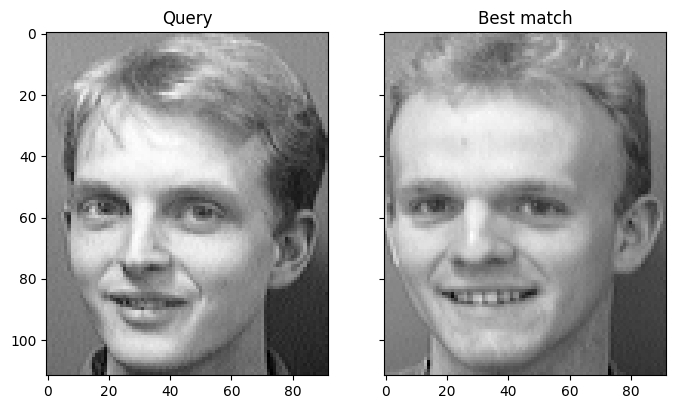

In [6]:
# Test on out-of-sample image of existing class
query = faces["s40/10.pgm"].flatten()
query_centered = query - mean_face
query_weight = np.dot(eigenfaces.T, query_centered)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=1)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()


Best match s39 with Euclidean distance 1559.997137


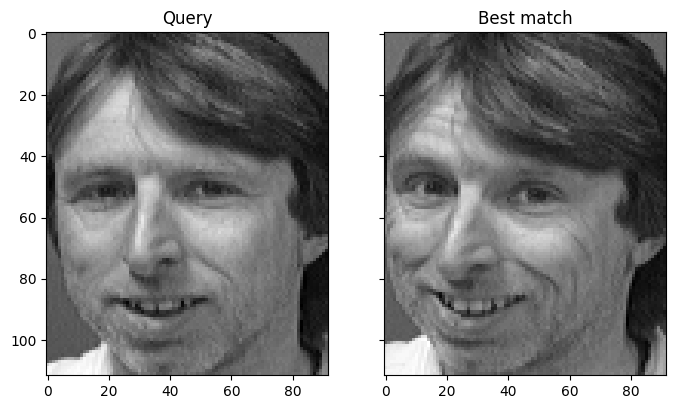

In [7]:
# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].flatten()
query_centered = query - mean_face
query_weight = np.dot(eigenfaces.T, query_centered)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=1)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()


In [8]:
selected_eigenfaces = [0, 5, 10, 15, 22]  #Enter the Eigen face label - 1!

In [9]:
test_face_label = "s6"

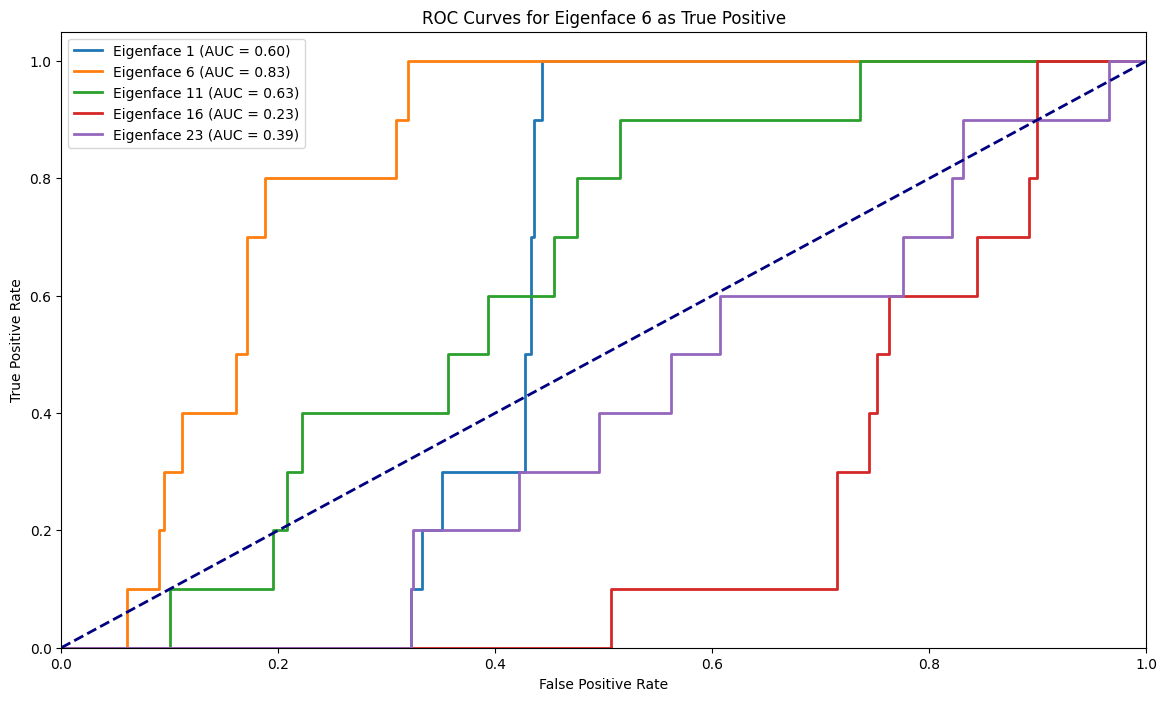

Mean Area Under the Curve (AUC) for Selected Eigenfaces: 0.535461741424802


In [10]:
plt.figure(figsize=(14, 8)) 
binary_labels = [1 if label == test_face_label else 0 for label in facelabel]

roc_auc_values = []
for eigenface_index in selected_eigenfaces:  # Iterate over selected eigenfaces
    fpr, tpr, _ = roc_curve(binary_labels, weights[:, eigenface_index])
    roc_auc = roc_auc_score(binary_labels, weights[:, eigenface_index])
    roc_auc_values.append(roc_auc)
    # Plotting individual ROC curves with different styles/colors
    plt.plot(fpr, tpr, label=f'Eigenface {eigenface_index+1} (AUC = {roc_auc:.2f})', linestyle='-', linewidth=2)

# Customize plot appearance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Eigenface {test_face_label[1:]} as True Positive')
plt.legend(loc="upper left")
plt.show()

# Report mean AUC
mean_roc_auc = np.mean(roc_auc_values)
print("Mean Area Under the Curve (AUC) for Selected Eigenfaces:", mean_roc_auc)


In [11]:
print("Binary Labels Shape:", len(binary_labels))
print("Weights Shape:", weights.shape)


Binary Labels Shape: 389
Weights Shape: (389, 50)
